In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.datasets import mnist

from vae_utils import *

Using TensorFlow backend.


# Data

In [3]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 784))
    x = x/255.
    #y = to_categorical(y, 10) #don't need to categorise y
    return x, y

train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

print(x_train.shape)

(60000, 784)


# PCA Model

In [4]:
# get the mean & cov of our data
b = np.mean(x_train, axis=0)
S = 0
for x in x_train:
    S+= np.outer(x-b, x-b)
S /= len(x_train)

In [5]:
# find the eigs and eigenvectors of the cov matrix and sort according
eigs, evecs = linalg.eig(S)

eig_pairs = list(zip(eigs, evecs.T))
eig_pairs.sort(reverse=True, key=lambda x: x[0])

In [9]:
# select the top q principle components
q = 2
d = len(eig_pairs)

pca_pairs = eig_pairs[:q]

pca_eigs = [pca_pairs[i][0] for i in range(len(pca_pairs))]
pca_vecs = [pca_pairs[i][1] for i in range(len(pca_pairs))]

# construct W and alpha^{-1}
L_q = diag(pca_eigs)
U_q = array(pca_vecs).T

alpha = 1/(d-q) * np.sum([eig_pairs[j][0] for j in range(q+1, d)])
W = np.matmul(U_q, L_q - alpha * eye(q))

# find p(z|x)
M = matmul(W.T, W) + alpha * eye(q)
p_z_x_mu = lambda x: matmul(matmul(inv(M), W.T), (x-b).T).T
p_z_x_sig = alpha * inv(M)

# find p(x)
p_x_mu = b
p_x_sig = matmul(W, W.T) + alpha * eye(d)
inv_p = inv(p_x_sig)

# find p(x|z)
p_x_z_mu = matmul(W, p_z_x_mu(x_train).T).T + b
p_x_z_sig = alpha

# calculate the elbo
elbo = -1/2 * np.log(det(2*pi*p_x_sig)) -1/2 * np.sum([matmul(matmul(x, inv_p), x) for x in x_train], axis=0)

C:\Users\User\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


In [27]:
np.sum([matmul(matmul(x, inv_p), x) for x in x_train], axis=0)

81077960.15107457

## Visualise

<IPython.core.display.Javascript object>


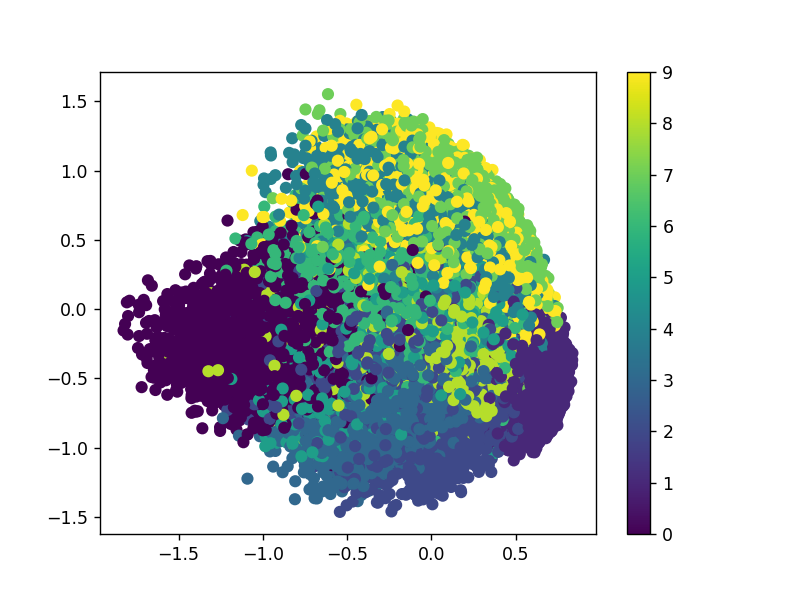

In [173]:
if q == 2:
    figure()
    m = p_z_x_mu(x_train)
    scatter(m[:, 0], m[:, 1], c=y_train)
    colorbar()